Загружено 156 изображений.

=== Сравнение форматов с оригиналом ===
PNG -> MSE: 0.00, SSIM: 1.0000
JPG -> MSE: 2.12, SSIM: 0.9932
BMP -> MSE: 0.00, SSIM: 1.0000


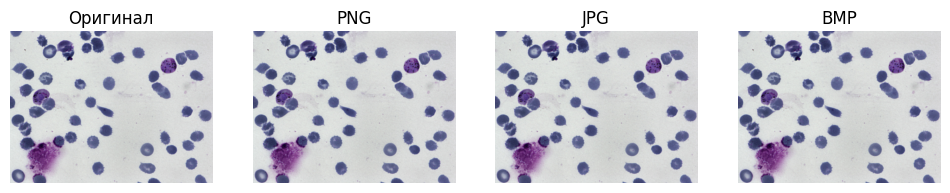

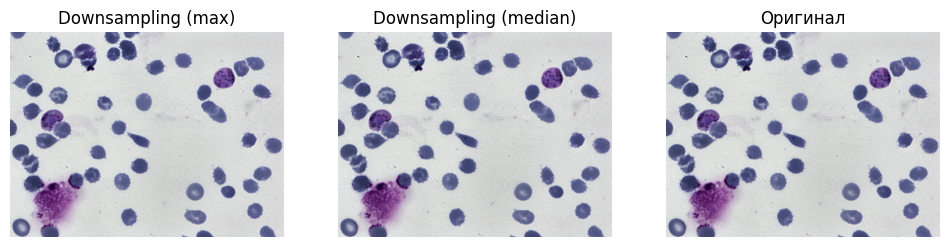

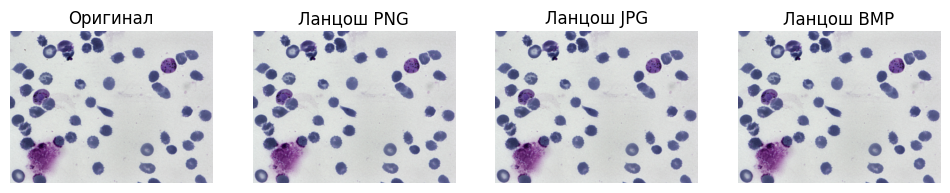


=== Сравнение восстановленных изображений ===
Восстановленный PNG -> MSE: 10.91, SSIM: 0.9663
Восстановленный JPG -> MSE: 11.31, SSIM: 0.9677
Восстановленный BMP -> MSE: 10.91, SSIM: 0.9663


In [1]:
import cv2
import numpy as np
import os
import glob
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt


# Пути
extract_path = "/content/sample_data/test_dataset"
save_folder = "/content/saved_images"
os.makedirs(save_folder, exist_ok=True)

# Функция загрузки изображений
def load_images_from_folder(folder_path):
    images = []
    filenames = glob.glob(f"{folder_path}/*")

    for filename in filenames:
        img = cv2.imread(filename)
        if img is not None:
            images.append((filename, img))

    return images

# Загружаем изображения
images = load_images_from_folder(extract_path)
print(f"Загружено {len(images)} изображений.")

# Сохранение в форматах PNG, JPG, BMP
save_formats = ["png", "jpg", "bmp"]
test_base_name = os.path.splitext(os.path.basename(images[0][0]))[0]  # Берем одно изображение
original_img = images[0][1]

for fmt in save_formats:
    save_path = os.path.join(save_folder, f"{test_base_name}.{fmt}")
    cv2.imwrite(save_path, original_img)

# Функция загрузки сохранённых изображений
def load_saved_images(folder_path, base_name):
    loaded_images = {}
    for fmt in save_formats:
        path = os.path.join(folder_path, f"{base_name}.{fmt}")
        img = cv2.imread(path)
        if img is not None:
            loaded_images[fmt] = img
    return loaded_images

# Загружаем сохраненные изображения
saved_images = load_saved_images(save_folder, test_base_name)

# Функция расчёта MSE
def mse(imageA, imageB):
    return np.mean((imageA - imageB) ** 2)

# Функция расчёта SSIM
def calculate_ssim(imageA, imageB):
    imageA_gray = cv2.cvtColor(imageA, cv2.COLOR_BGR2GRAY)
    imageB_gray = cv2.cvtColor(imageB, cv2.COLOR_BGR2GRAY)
    return ssim(imageA_gray, imageB_gray)

# Сравнение форматов с оригиналом
comparison_results = {fmt: (mse(original_img, saved_images[fmt]), calculate_ssim(original_img, saved_images[fmt])) for fmt in save_formats}

print("\n=== Сравнение форматов с оригиналом ===")
for fmt, (mse_val, ssim_val) in comparison_results.items():
    print(f"{fmt.upper()} -> MSE: {mse_val:.2f}, SSIM: {ssim_val:.4f}")

# Визуализация изображений в разных форматах
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
axes[0].imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
axes[0].set_title("Оригинал")
axes[0].axis("off")

for i, fmt in enumerate(save_formats):
    axes[i + 1].imshow(cv2.cvtColor(saved_images[fmt], cv2.COLOR_BGR2RGB))
    axes[i + 1].set_title(f"{fmt.upper()}")
    axes[i + 1].axis("off")

plt.show()

# Функция уменьшения разрешения (downsampling) - max pooling
def downsample_max(image, factor=2):
    h, w, _ = image.shape
    new_h, new_w = h // factor, w // factor
    downsampled = np.zeros((new_h, new_w, 3), dtype=np.uint8)

    for i in range(new_h):
        for j in range(new_w):
            region = image[i*factor:(i+1)*factor, j*factor:(j+1)*factor]
            downsampled[i, j] = np.max(region, axis=(0, 1))

    return downsampled

# Функция уменьшения разрешения - медианное усреднение
def downsample_median(image, factor=2):
    h, w, _ = image.shape
    new_h, new_w = h // factor, w // factor
    downsampled = np.zeros((new_h, new_w, 3), dtype=np.uint8)

    for i in range(new_h):
        for j in range(new_w):
            region = image[i*factor:(i+1)*factor, j*factor:(j+1)*factor]
            downsampled[i, j] = np.median(region, axis=(0, 1)).astype(np.uint8)

    return downsampled

# Применяем уменьшение разрешения
factor = 2
downsampled_max = downsample_max(original_img, factor)
downsampled_median = downsample_median(original_img, factor)

# Восстановление Ланцоша
def upscale_lanczos(image, scale=2):
    h, w = image.shape[:2]
    new_h, new_w = h * scale, w * scale
    return cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_LANCZOS4)

# Восстанавливаем изображения Ланцоша
upscaled_images = {fmt: upscale_lanczos(downsample_max(saved_images[fmt], factor), factor) for fmt in save_formats}

# Визуализация downsampling и восстановления
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(cv2.cvtColor(downsampled_max, cv2.COLOR_BGR2RGB))
axes[0].set_title("Downsampling (max)")
axes[0].axis("off")

axes[1].imshow(cv2.cvtColor(downsampled_median, cv2.COLOR_BGR2RGB))
axes[1].set_title("Downsampling (median)")
axes[1].axis("off")

axes[2].imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
axes[2].set_title("Оригинал")
axes[2].axis("off")

plt.show()

fig, axes = plt.subplots(1, 4, figsize=(12, 4))
axes[0].imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
axes[0].set_title("Оригинал")
axes[0].axis("off")

for i, fmt in enumerate(save_formats):
    axes[i + 1].imshow(cv2.cvtColor(upscaled_images[fmt], cv2.COLOR_BGR2RGB))
    axes[i + 1].set_title(f"Ланцош {fmt.upper()}")
    axes[i + 1].axis("off")

plt.show()

# Сравнение восстановленных изображений с оригиналом
upscale_comparison = {fmt: (mse(original_img, upscaled_images[fmt]), calculate_ssim(original_img, upscaled_images[fmt])) for fmt in save_formats}

print("\n=== Сравнение восстановленных изображений ===")
for fmt, (mse_val, ssim_val) in upscale_comparison.items():
    print(f"Восстановленный {fmt.upper()} -> MSE: {mse_val:.2f}, SSIM: {ssim_val:.4f}")